In [40]:
from denovo_utils.parsers.converters import SpectralisParser, DenovoEngineConverter
from denovo_utils.analysis.pandas_utils import (
    get_decoy_status,
    collapse_casanovo_score,
    get_spectralis_score,
    get_psm_type,
    amino_acid_converter,
    drop_charge
)
import pandas as pd
import os

from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from psm_utils import PSMList, PSM

# 0. Load the data

In [22]:
filename="F06"

root_data="/home/samva/Doctorate/data_directory/denovo_project"
mgf_path=os.path.join(root_data, "mgf_filtered", filename + ".mgf")
results_dir=os.path.join(root_data, "denovo_results")

In [23]:
parser_spectralis = SpectralisParser(
    mgf_path=mgf_path,
    results_dir=results_dir
)

# Casanovo, instanovo, pepnet, contranovo ran together
parser_spectralis.parse(
    path_spectralis=os.path.join(
        results_dir,
        "refinement/spectralis/pt1", filename + "_annotated_rescoring.csv"
    )
)

# NovoB, Novor, PepNovo+ ran together
parser_spectralis.parse(
    path_spectralis=os.path.join(
        results_dir,
        "refinement/spectralis/pt2", filename + "_annotated_rescoring.csv"
    )
)

# Sage results ran separately
parser_spectralis.parse(
    path_spectralis=os.path.join(
        results_dir,
        "refinement/spectralis/pt3", filename + "_annotated_rescoring.csv"
    )
)

['Casanovo4.2.0', 'InstaNovo', 'PepNet', 'ContraNovo']


100%|██████████| 40545/40545 [00:00<00:00, 163030.62it/s]


['NovoB', 'Novor', 'PepNovo+']


100%|██████████| 67487/67487 [00:00<00:00, 165261.85it/s]


['sage']


100%|██████████| 76181/76181 [00:00<00:00, 154061.25it/s]


In [24]:
parser_spectralis.added_results

{'Casanovo4.2.0': True,
 'InstaNovo': True,
 'PepNet': True,
 'ContraNovo': True,
 'NovoB': True,
 'Novor': True,
 'PepNovo+': True,
 'percolator': False,
 'sage': True}

In [25]:
df = parser_spectralis.dataframe

Do some preprocessing of the data:
- Collapse casanovo and contranovo scores (as negative predictions point to peptides not matching the precursor mass)?
- Get spectralis scores
- Get psm type
- Preprocess the sequence predictions so:
    - I -> L
    - N[UNIMOD:7] -> D
    - Q[UNIMOD:7] -> E
- Drop other modification predictions ? As these might not be compatible with spectralis scoring

In [26]:
mapping_aa = {
    "I": "L",
    "N[UNIMOD:7]": "D",
    "Q[UNIMOD:7]": "E"
}

df["spectralis_score"] = df.apply(get_spectralis_score, axis=1)
df["score"] = df.apply(collapse_casanovo_score, axis=1)
df["psm_type"] = df.apply(get_psm_type, axis=1)

df["peptidoform"] = df.apply(drop_charge, axis=1)
df["peptide"] = df.apply(
    lambda x: amino_acid_converter(x, mapping_aa),
    axis=1
)
df["peptide"] = df.apply(lambda x: x["peptide"].proforma, axis=1)

# Prevent PSM-pydantic errors
df["rank"] = 1

In [27]:
df.to_pickle(filename+"_merged.pkl")

---

In [ ]:
df.source.value_counts()

PepNet           83186
Novor            80955
Casanovo4.2.0    80842
InstaNovo        80759
NovoB            78630
percolator       75802
PepNovo+         67487
ContraNovo       40545
Name: source, dtype: int64

In [12]:
df.to_pickle("psms_merged.pkl")

---

# 1. Score distributions

### 1.1 Original scores

In [30]:
df = pd.read_pickle("F06_merged.pkl")

In [93]:
df.tail(5)

,peptidoform,spectrum_id,run,collection,spectrum,is_decoy,score,qvalue,pep,precursor_mz,retention_time,ion_mobility,protein_list,rank,source,provenance_data,metadata,rescoring_features,spectralis_score
588201,"((S, None), (L, None), (A, None), (T, None), (...",controllerType=0 controllerNumber=1 scan=52157,None,None,None,True,-2.54105,0.162541,1.0,NaN,NaN,None,[decoy_generic_k99_188488_3|decoy_k99_188488_3|],None,percolator,{'filename': '/home/samva/Doctorate/data_direc...,{},"{'score': -2.54105, 'spectralis_score': -2.315...",-2.315599
588202,"((E, [UNIMOD:23]), (T, None), (S, None), (K, N...",controllerType=0 controllerNumber=1 scan=74186,None,None,None,True,-2.55686,0.162569,1.0,NaN,NaN,None,[decoy_generic_k99_40941_1|decoy_k99_40941_1|],None,percolator,{'filename': '/home/samva/Doctorate/data_direc...,{},"{'score': -2.55686, 'spectralis_score': -3.099...",-3.099071
588203,"((N, None), (N, None), (Q, None), (S, None), (...",controllerType=0 controllerNumber=1 scan=82978,None,None,None,True,-2.56935,0.162572,1.0,NaN,NaN,None,[decoy_generic_k99_152895_2|decoy_k99_152895_2...,None,percolator,{'filename': '/home/samva/Doctorate/data_direc...,{},"{'score': -2.56935, 'spectralis_score': -2.342...",-2.342164
588204,"((M, [UNIMOD:35]), (S, None), (R, None), (W, N...",controllerType=0 controllerNumber=1 scan=44396,None,None,None,True,-2.63027,0.162575,1.0,NaN,NaN,None,[decoy_generic_sp|decoy_Q6YHU6|THADA_HUMAN-Thy...,None,percolator,{'filename': '/home/samva/Doctorate/data_direc...,{},"{'score': -2.63027, 'spectralis_score': -2.604...",-2.604863
588205,"((E, None), (E, None), (S, None), (F, None), (...",controllerType=0 controllerNumber=1 scan=56558,None,None,None,True,-2.99326,0.162602,1.0,NaN,NaN,None,[decoy_generic_k99_14897_7|decoy_k99_14897_7|],None,percolator,{'filename': '/home/samva/Doctorate/data_direc...,{},"{'score': -2.99326, 'spectralis_score': -2.681...",-2.681654


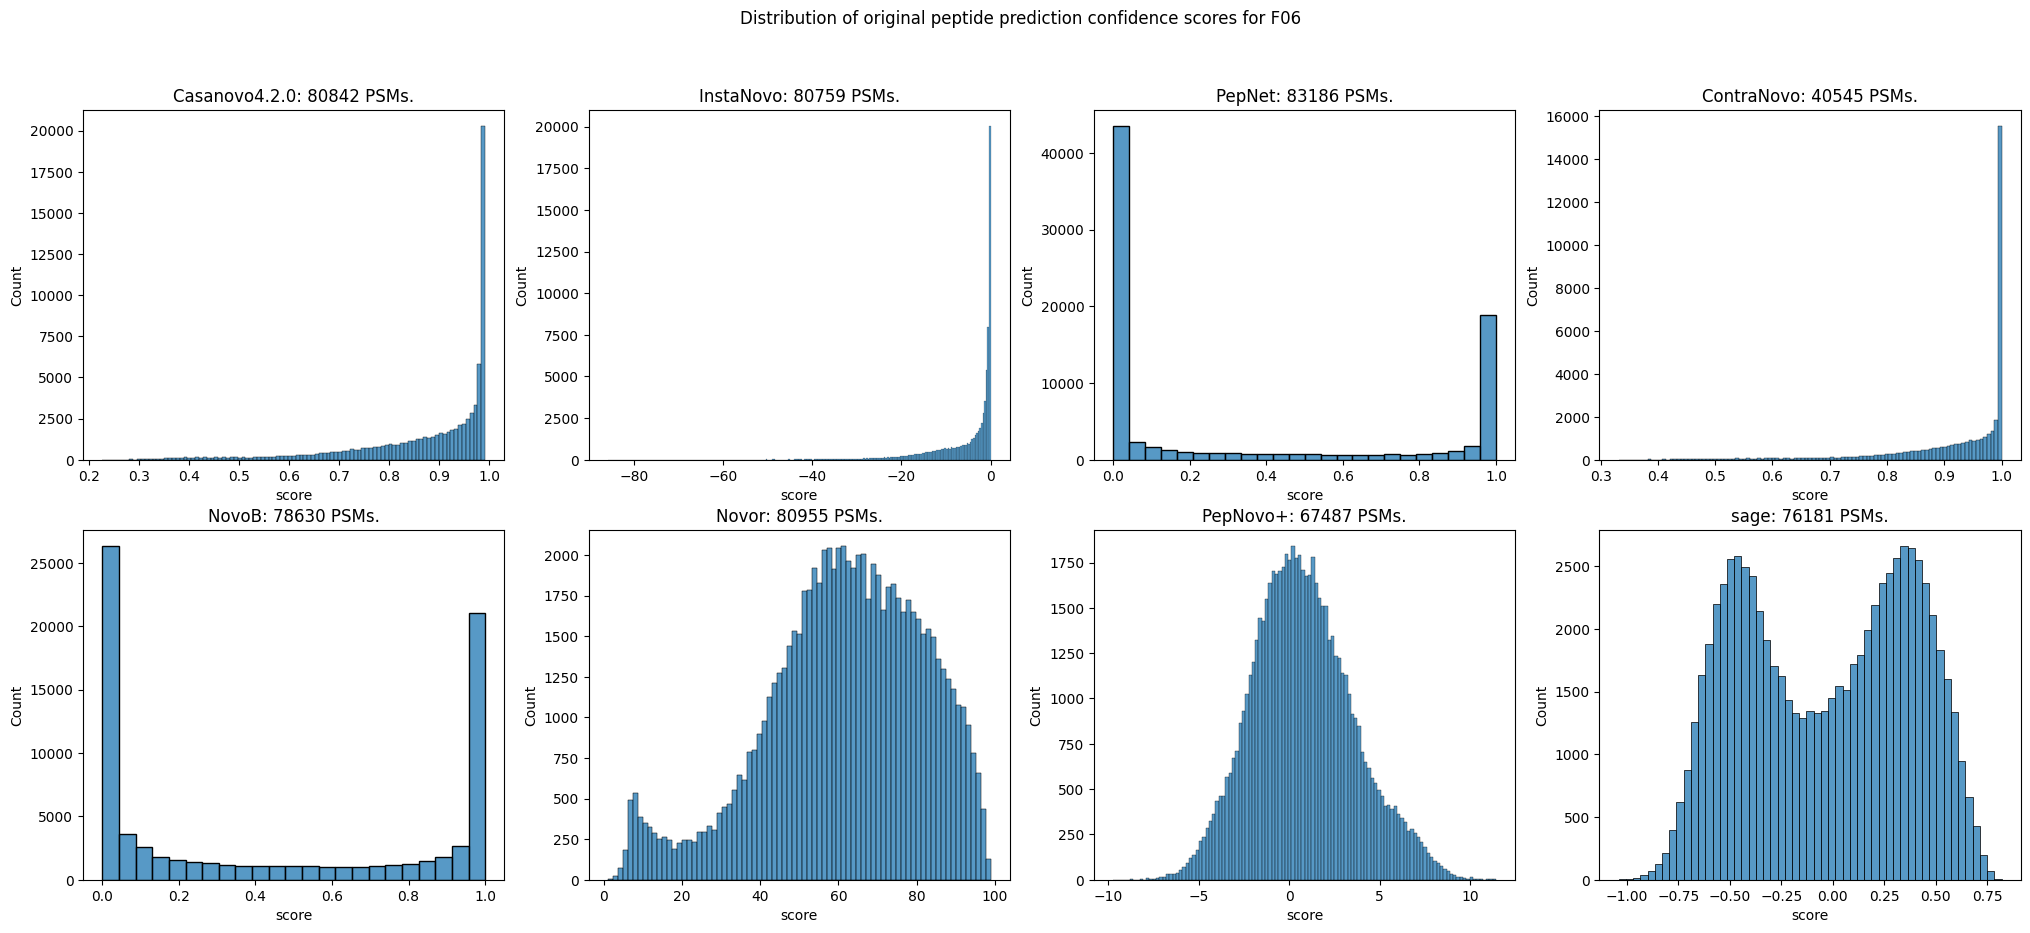

In [31]:
fig, ax = plt.subplots(2,4, figsize=(25,10))

x=0

fig.suptitle("Distribution of original peptide prediction confidence scores for F06")
for y, engine in enumerate(df.source.unique()):
    if y >= 4:
        x=1
        y-=4
    selection = df[
        df.source==engine
    ]
    sns.histplot(
        selection["score"],
        ax=ax[x][y]
    )
    ax[x][y].set_title(f"{engine}: {len(selection)} PSMs.")

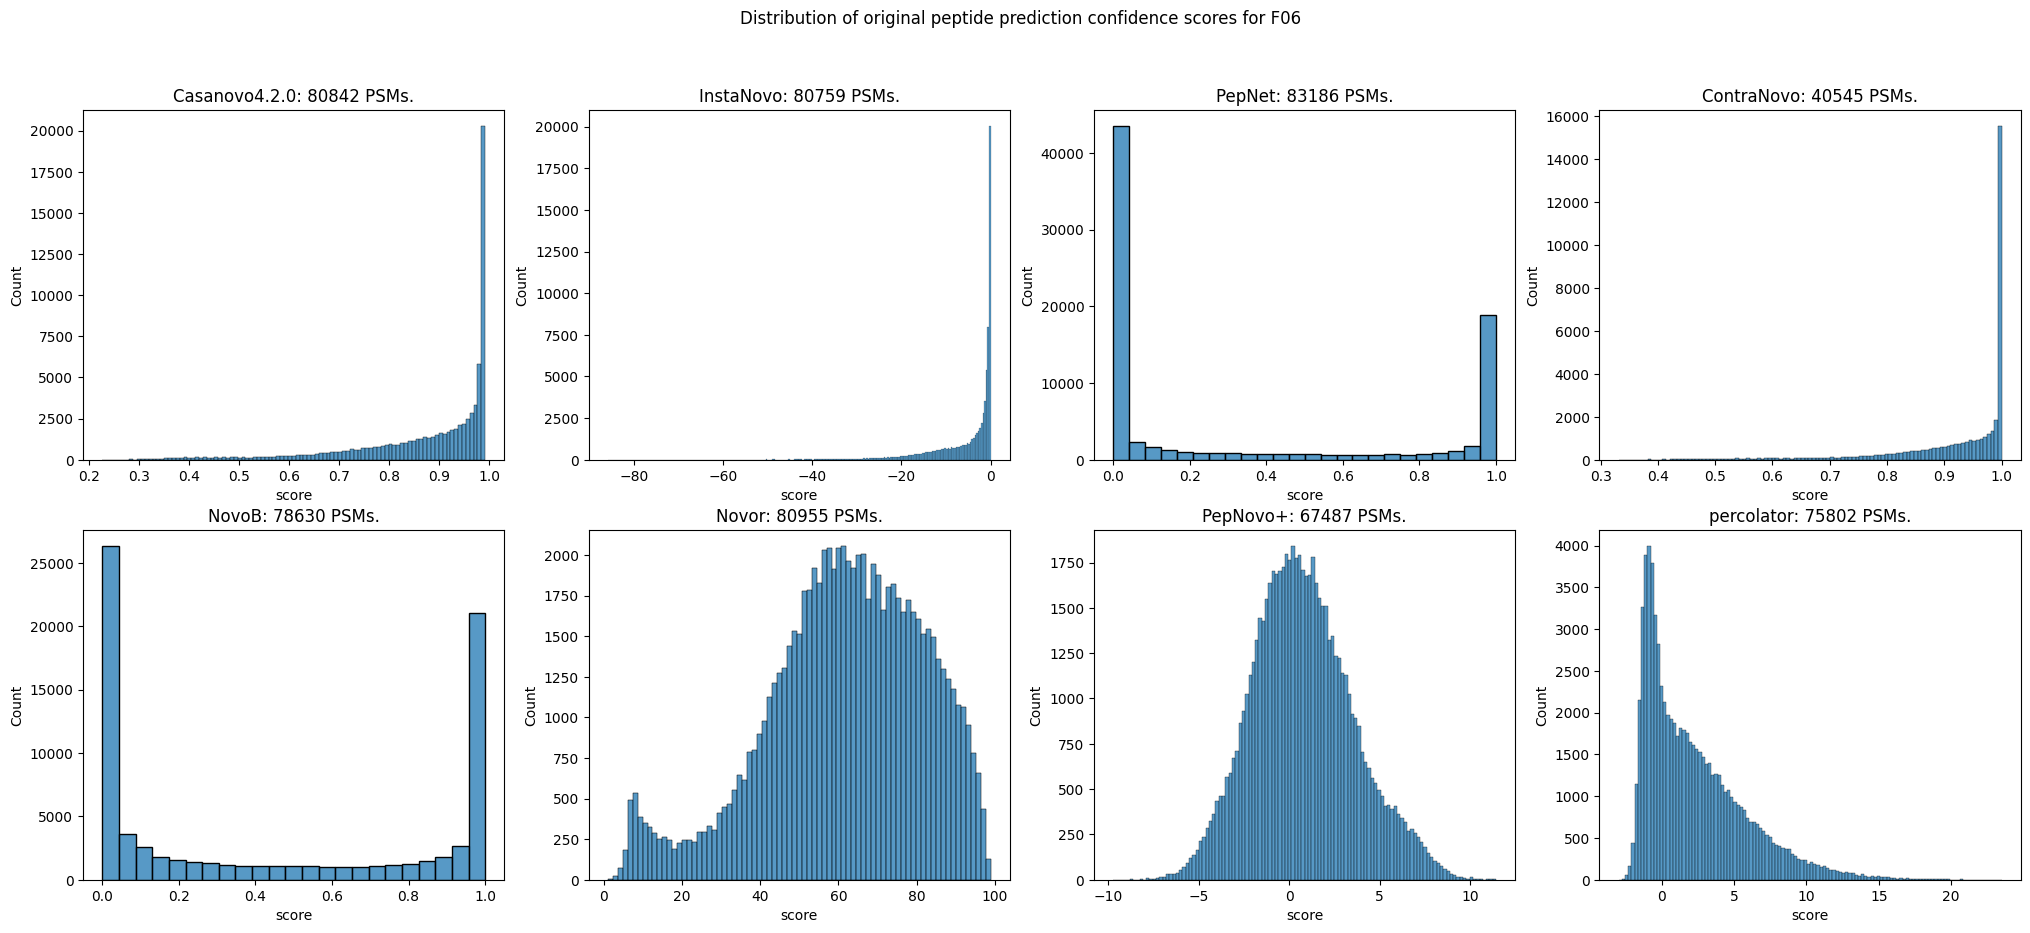

In [49]:
fig, ax = plt.subplots(2,4, figsize=(25,10))

x=0

fig.suptitle("Distribution of original peptide prediction confidence scores for F06")
for y, engine in enumerate(df.source.unique()):
    if y >= 4:
        x=1
        y-=4
    selection = df[
        df.source==engine
    ]
    sns.histplot(
        selection["score"],
        ax=ax[x][y]
    )
    ax[x][y].set_title(f"{engine}: {len(selection)} PSMs.")

It is useful to calculate the pairwise correlations of the generated scores between the tools. If there is a high correlation, this means that these two tools are confident or not confident for their predictions of the same spectra. In other words, the perceived confidence of the prediction is entirely dependent on the underlying raw data, and not on the improved generalization of a given tool.

In [32]:
# 26.244 spectra have acquired an identification by every engine.
common_identification_boolean = df.groupby("spectrum_id").count()["source"]==8
common_identifications_list = common_identification_boolean[common_identification_boolean].index.tolist()
print(df.spectrum_id.nunique(), len(common_identifications_list), "{:.2f}% spectra identified with significant target".format(len(common_identifications_list)/df.spectrum_id.nunique()*100))


83187 30317 36.44% spectra identified with significant target


In [33]:
df.head(3)

,peptidoform,spectrum_id,run,collection,spectrum,is_decoy,score,qvalue,pep,precursor_mz,...,ion_mobility,protein_list,rank,source,provenance_data,metadata,rescoring_features,spectralis_score,psm_type,peptide
0,"((E, None), (S, None), (E, None), (E, None), (...",controllerType=0 controllerNumber=1 scan=7,F06.mztab,None,None,None,0.439812,NaN,None,439.843872,...,None,None,1,Casanovo4.2.0,{},"{'aa_scores': '0.66992,0.39521,0.31139,0.28170...",{'spectralis_score': -1.8043877871353609},-1.804388,None,ESEEEEE
1,"((L, None), (E, None), (P, None), (E, None), (...",controllerType=0 controllerNumber=1 scan=13,F06.mztab,None,None,None,0.392842,NaN,None,1099.519043,...,None,None,1,Casanovo4.2.0,{},"{'aa_scores': '0.33022,0.32784,0.30110,0.36436...",{'spectralis_score': -2.474801036219871},-2.474801,None,LEPEPTPEEEEEEEEEEK
2,"((G, None), (S, None), (S, None), (S, None), (...",controllerType=0 controllerNumber=1 scan=17,F06.mztab,None,None,None,0.336586,NaN,None,753.770935,...,None,None,1,Casanovo4.2.0,{},"{'aa_scores': '0.41169,0.23674,0.25019,0.25733...",{'spectralis_score': -2.2361644109689265},-2.236164,None,GSSSSSGSSSSSSSSSR


In [34]:
score_matrix = df[["spectrum_id", "score", "source"]].melt(id_vars=["spectrum_id", "source"], value_vars='score').pivot_table(values="value", index="spectrum_id", columns="source")
score_matrix.head(5)

source,Casanovo4.2.0,ContraNovo,InstaNovo,NovoB,Novor,PepNet,PepNovo+,sage
spectrum_id,,,,,,,,
controllerType=0 controllerNumber=1 scan=1000,0.510819,0.588593,-13.777768,0.000441,9.5,0.0000,NaN,NaN
controllerType=0 controllerNumber=1 scan=10000,0.825504,0.870897,-3.389699,0.066598,58.8,0.0013,0.050,0.217688
controllerType=0 controllerNumber=1 scan=10001,0.988711,NaN,-0.135967,0.942835,84.1,0.9951,1.183,-0.605949
controllerType=0 controllerNumber=1 scan=10003,0.401784,0.559872,NaN,0.000000,6.6,0.0000,NaN,NaN
controllerType=0 controllerNumber=1 scan=10004,0.780700,NaN,-7.087308,0.003440,49.2,0.0431,-1.768,0.317005


In [35]:
score_matrix_complete = score_matrix[score_matrix.isna().sum(axis=1)==0]

Text(0.5, 1.0, 'Spearman correlation of denovo engine prediction scores')

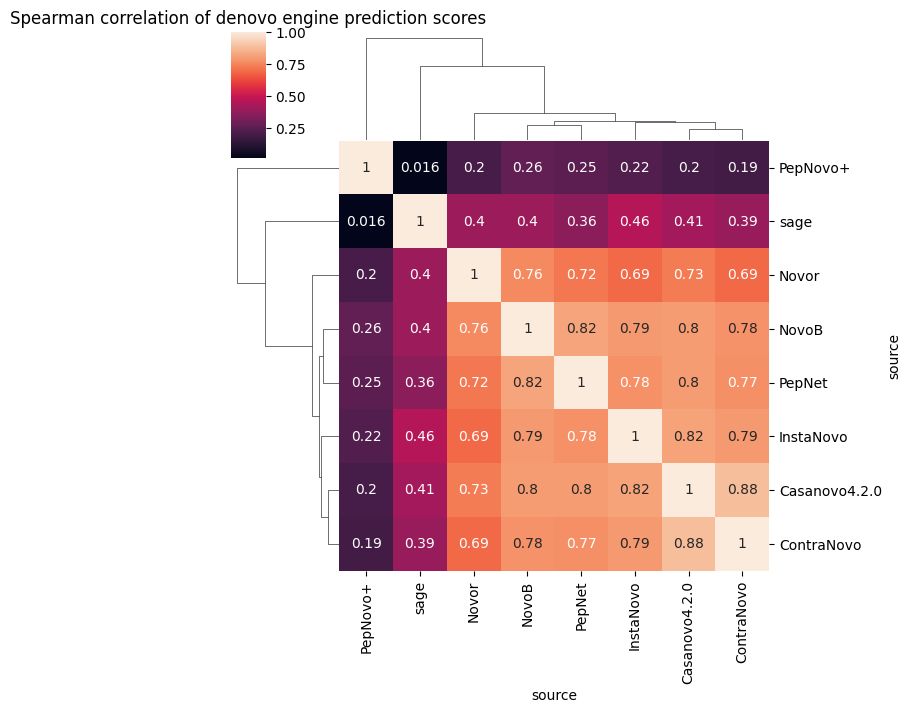

In [36]:
sns.clustermap(score_matrix_complete.corr(method="spearman"), annot=True, figsize=(7,7))
plt.title("Spearman correlation of denovo engine prediction scores")

### 1.2 Spectralis rescored

In [55]:
df.head()

,peptidoform,spectrum_id,run,collection,spectrum,is_decoy,score,qvalue,pep,precursor_mz,retention_time,ion_mobility,protein_list,rank,source,provenance_data,metadata,rescoring_features,spectralis_score
0,"((E, None), (S, None), (E, None), (E, None), (...",controllerType=0 controllerNumber=1 scan=7,F06.mztab,None,None,None,0.439812,NaN,NaN,439.843872,1.511676,None,None,None,Casanovo4.2.0,{},"{'aa_scores': '0.66992,0.39521,0.31139,0.28170...",{'spectralis_score': -1.8043877871353609},-1.804388
1,"((L, None), (E, None), (P, None), (E, None), (...",controllerType=0 controllerNumber=1 scan=13,F06.mztab,None,None,None,0.392842,NaN,NaN,1099.519043,2.729931,None,None,None,Casanovo4.2.0,{},"{'aa_scores': '0.33022,0.32784,0.30110,0.36436...",{'spectralis_score': -2.474801036219871},-2.474801
2,"((G, None), (S, None), (S, None), (S, None), (...",controllerType=0 controllerNumber=1 scan=17,F06.mztab,None,None,None,0.336586,NaN,NaN,753.770935,3.321308,None,None,None,Casanovo4.2.0,{},"{'aa_scores': '0.41169,0.23674,0.25019,0.25733...",{'spectralis_score': -2.2361644109689265},-2.236164
3,"((S, None), (S, None), (P, None), (A, None), (...",controllerType=0 controllerNumber=1 scan=22,F06.mztab,None,None,None,0.402539,NaN,NaN,775.376953,4.268059,None,None,None,Casanovo4.2.0,{},"{'aa_scores': '0.62083,0.31088,0.29389,0.25741...",{'spectralis_score': -2.2724231511662603},-2.272423
4,"((E, None), (L, None), (D, None), (L, None), (...",controllerType=0 controllerNumber=1 scan=23,F06.mztab,None,None,None,0.307082,NaN,NaN,816.214600,4.358558,None,None,None,Casanovo4.2.0,{},"{'aa_scores': '0.43824,0.25090,0.21244,0.25887...",{'spectralis_score': -1.9202066904386164},-1.920207


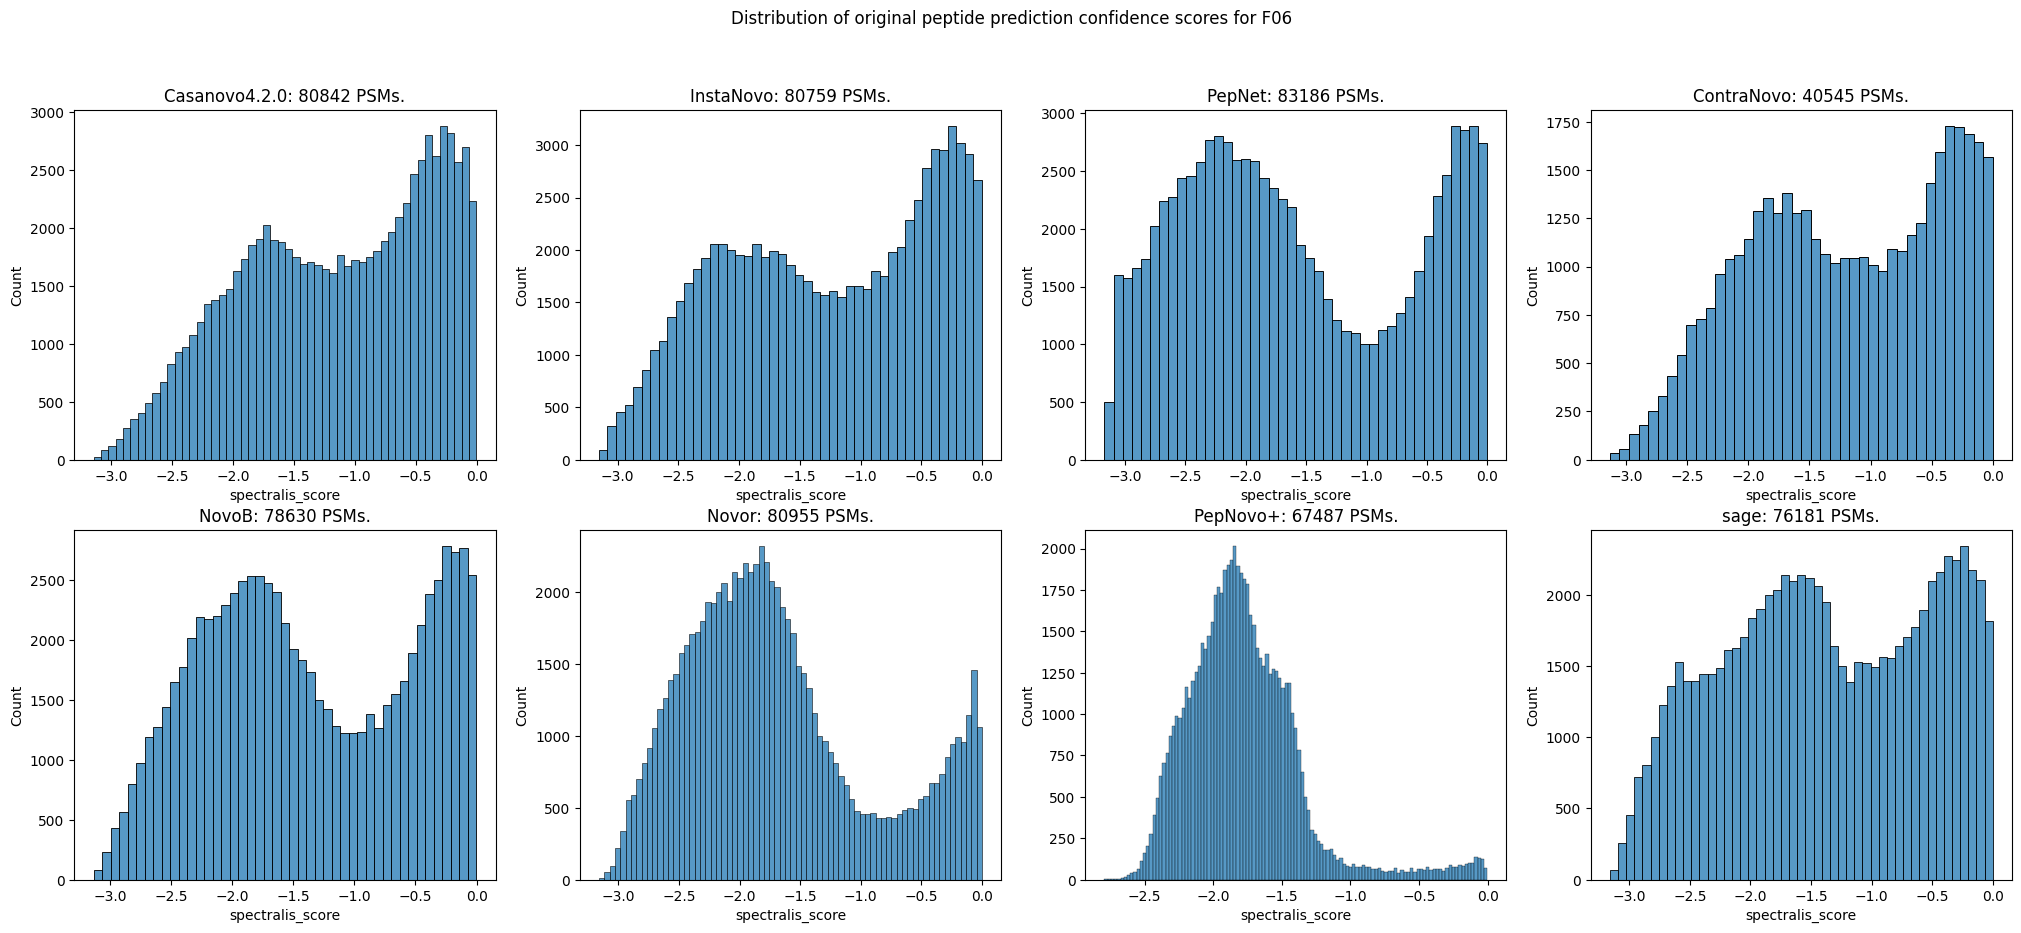

In [37]:
fig, ax = plt.subplots(2,4, figsize=(25,10))

x=0

fig.suptitle("Distribution of original peptide prediction confidence scores for F06")
for y, engine in enumerate(df.source.unique()):
    if y >= 4:
        x=1
        y-=4
    selection = df[
        df.source==engine
    ]
    sns.histplot(
        selection["spectralis_score"],
        ax=ax[x][y]
    )
    ax[x][y].set_title(f"{engine}: {len(selection)} PSMs.")

In [57]:
score_matrix_spectralis = df[["spectrum_id", "spectralis_score", "source"]].melt(id_vars=["spectrum_id", "source"], value_vars='spectralis_score').pivot_table(values="value", index="spectrum_id", columns="source")
score_matrix_complete_spectralis = score_matrix_spectralis[score_matrix_spectralis.isna().sum(axis=1)==0]
score_matrix.head(5)

source,Casanovo4.2.0,ContraNovo,InstaNovo,NovoB,Novor,PepNet,PepNovo+,percolator
spectrum_id,,,,,,,,
controllerType=0 controllerNumber=1 scan=1000,0.510819,0.588593,-13.777768,0.000441,9.5,0.0000,NaN,NaN
controllerType=0 controllerNumber=1 scan=10000,0.825504,0.870897,-3.389699,0.066598,58.8,0.0013,0.050,0.384595
controllerType=0 controllerNumber=1 scan=10001,0.988711,NaN,-0.135967,0.942835,84.1,0.9951,1.183,NaN
controllerType=0 controllerNumber=1 scan=10003,0.401784,0.559872,NaN,0.000000,6.6,0.0000,NaN,NaN
controllerType=0 controllerNumber=1 scan=10004,0.780700,NaN,-7.087308,0.003440,49.2,0.0431,-1.768,3.015040


Text(0.5, 1.0, 'Spearman correlation of spectralis scores of de novo predictions')

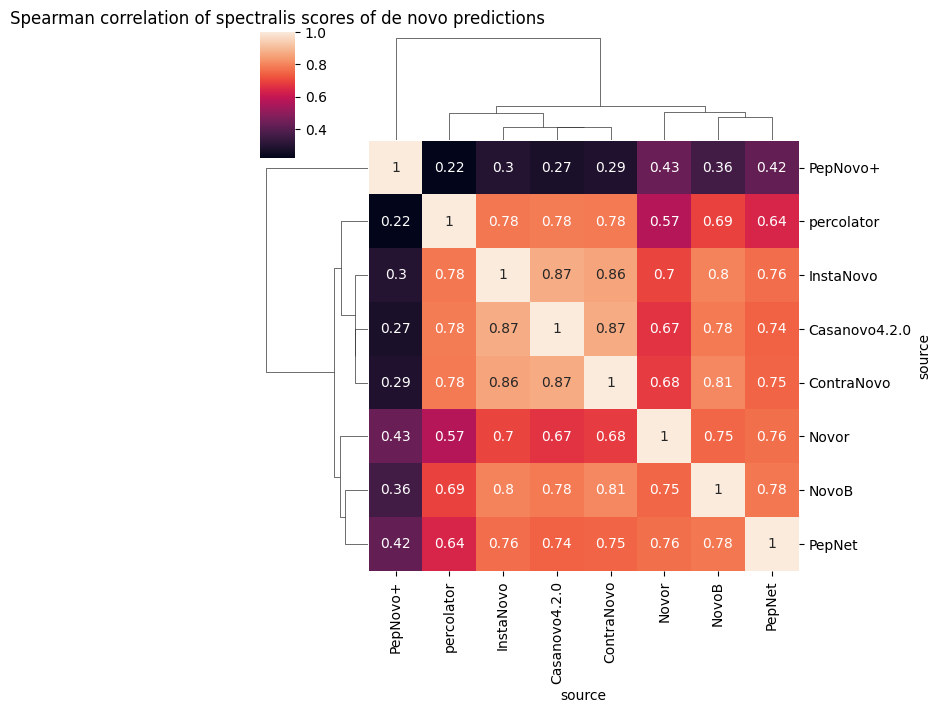

In [58]:
sns.clustermap(score_matrix_complete_spectralis.corr(method="spearman"), annot=True, figsize=(7,7))
plt.title("Spearman correlation of spectralis scores of de novo predictions")

Seems like the casanovo scores correlate best with the scores from the search engine

### 1.3 Correlation of the scores

Correlation of the spectralis score with each of the search engines

In [61]:
def correlate_scores(df, corr_type="spearman"):
    if corr_type=="spearman":
        return spearmanr(df["score"], df["spectralis_score"])[0]
    elif corr_type=="pearson":
        return pearsonr(df["score"], df["spectralis_score"])[0]
    else:
        raise Exception("Wrong input for corr_type. Only 'spearman' and 'pearson' supported.")

/tmp/ipykernel_113094/1846531159.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("source").apply(lambda x: correlate_scores(x, "spearman")).plot(kind="bar")


<Axes: xlabel='source'>

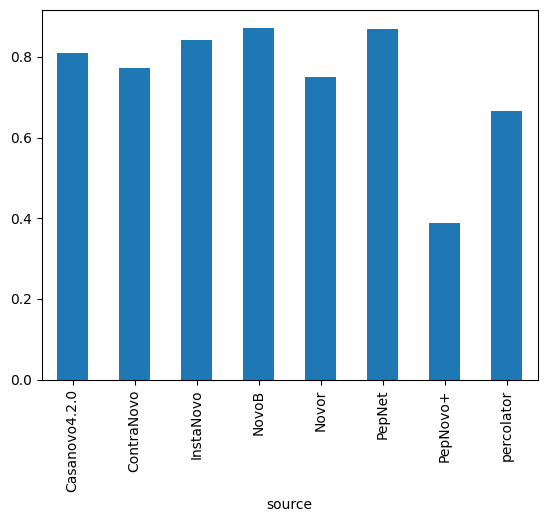

In [62]:
df.groupby("source").apply(lambda x: correlate_scores(x, "spearman")).plot(kind="bar")

/tmp/ipykernel_113094/1828089021.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("source").apply(lambda x: correlate_scores(x, "pearson")).plot(kind="bar")


<Axes: xlabel='source'>

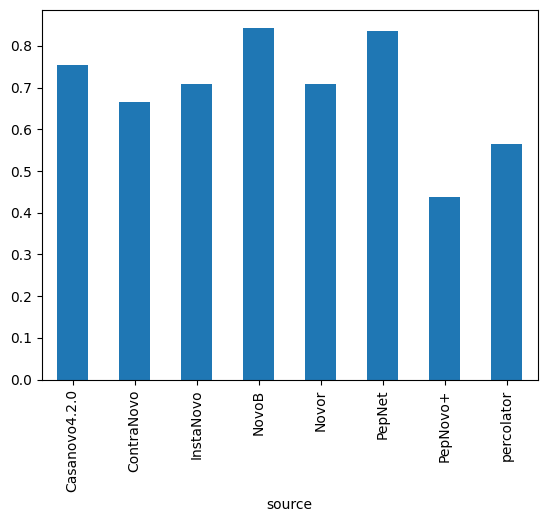

In [63]:
df.groupby("source").apply(lambda x: correlate_scores(x, "pearson")).plot(kind="bar")

It is worrying to see that the scores from percolator dont match the ones from spectralis well...

In [64]:
df_percolator = df[
    df.source=="percolator"
]
df_percolator = df_percolator.copy()
df_percolator["significant"] =  df_percolator["qvalue"] < .01

<Axes: xlabel='score', ylabel='spectralis_score'>

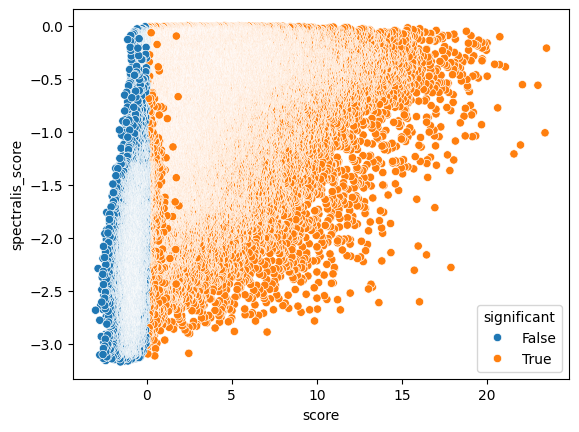

In [65]:
sns.scatterplot(
    df_percolator,
    x="score",
    y="spectralis_score",
    hue="significant"
)

In [38]:
def plot_correlation_scores(df, source, ax=None, plot_type="scatter"):
    selection = df[df["source"]==source]
    if plot_type=="scatter":
        sns.scatterplot(
            selection,
            x="score",
            y="spectralis_score",
            ax=ax
        )
    elif plot_type=="kde":
        sns.kdeplot(
            selection,
            x="score",
            y="spectralis_score",
            ax=ax
        )
    else:
        raise Exception("Plot type not supported. Only 'scatter' and 'kde' are supported.")

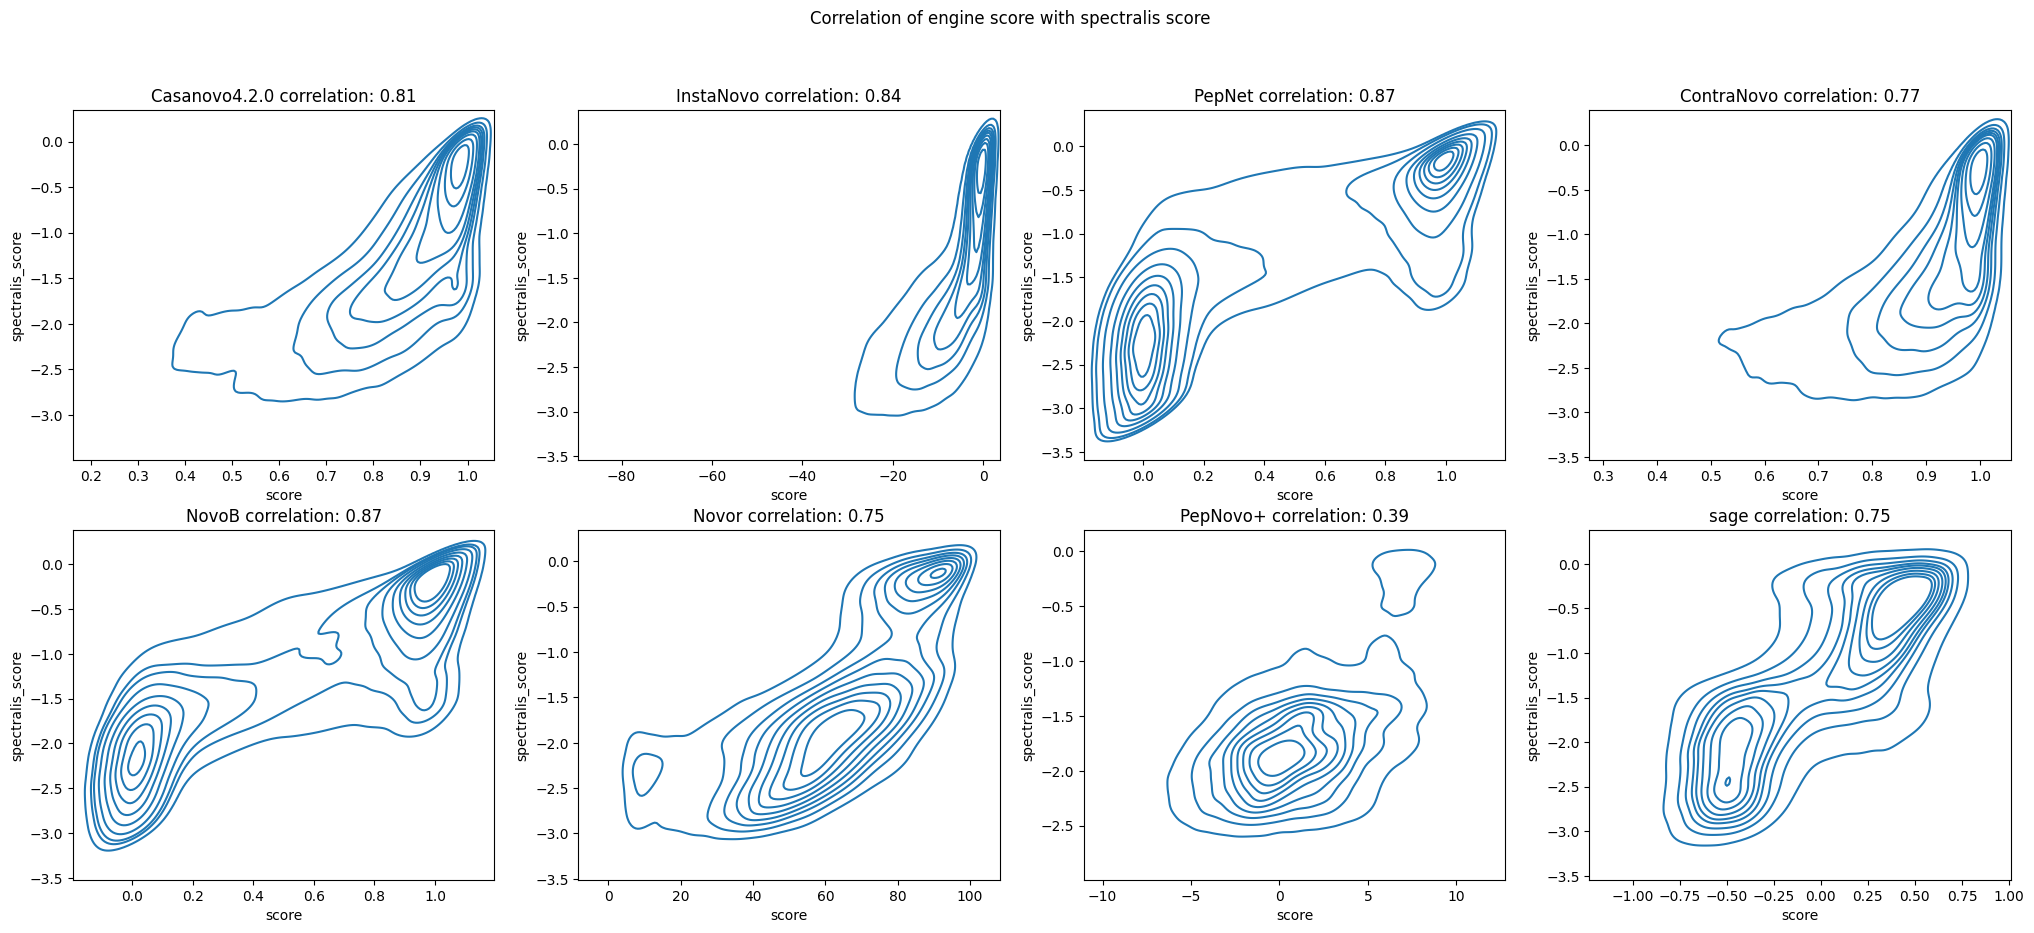

In [41]:
fig, ax = plt.subplots(2,4, figsize=(25,10))
x=0

fig.suptitle("Correlation of engine score with spectralis score")
for y, engine in enumerate(df.source.unique()):
    if y >= 4:
        x=1
        y-=4
    ax_selection = ax[x][y]
    plot_correlation_scores(df, source=engine, ax=ax_selection, plot_type="kde")
    ax_selection.set_title("{} correlation: {:.2f}".format(
        engine,
        spearmanr(
            df.loc[df["source"]==engine, "score"],
            df.loc[df["source"]==engine, "spectralis_score"]
        )[0]
    ))

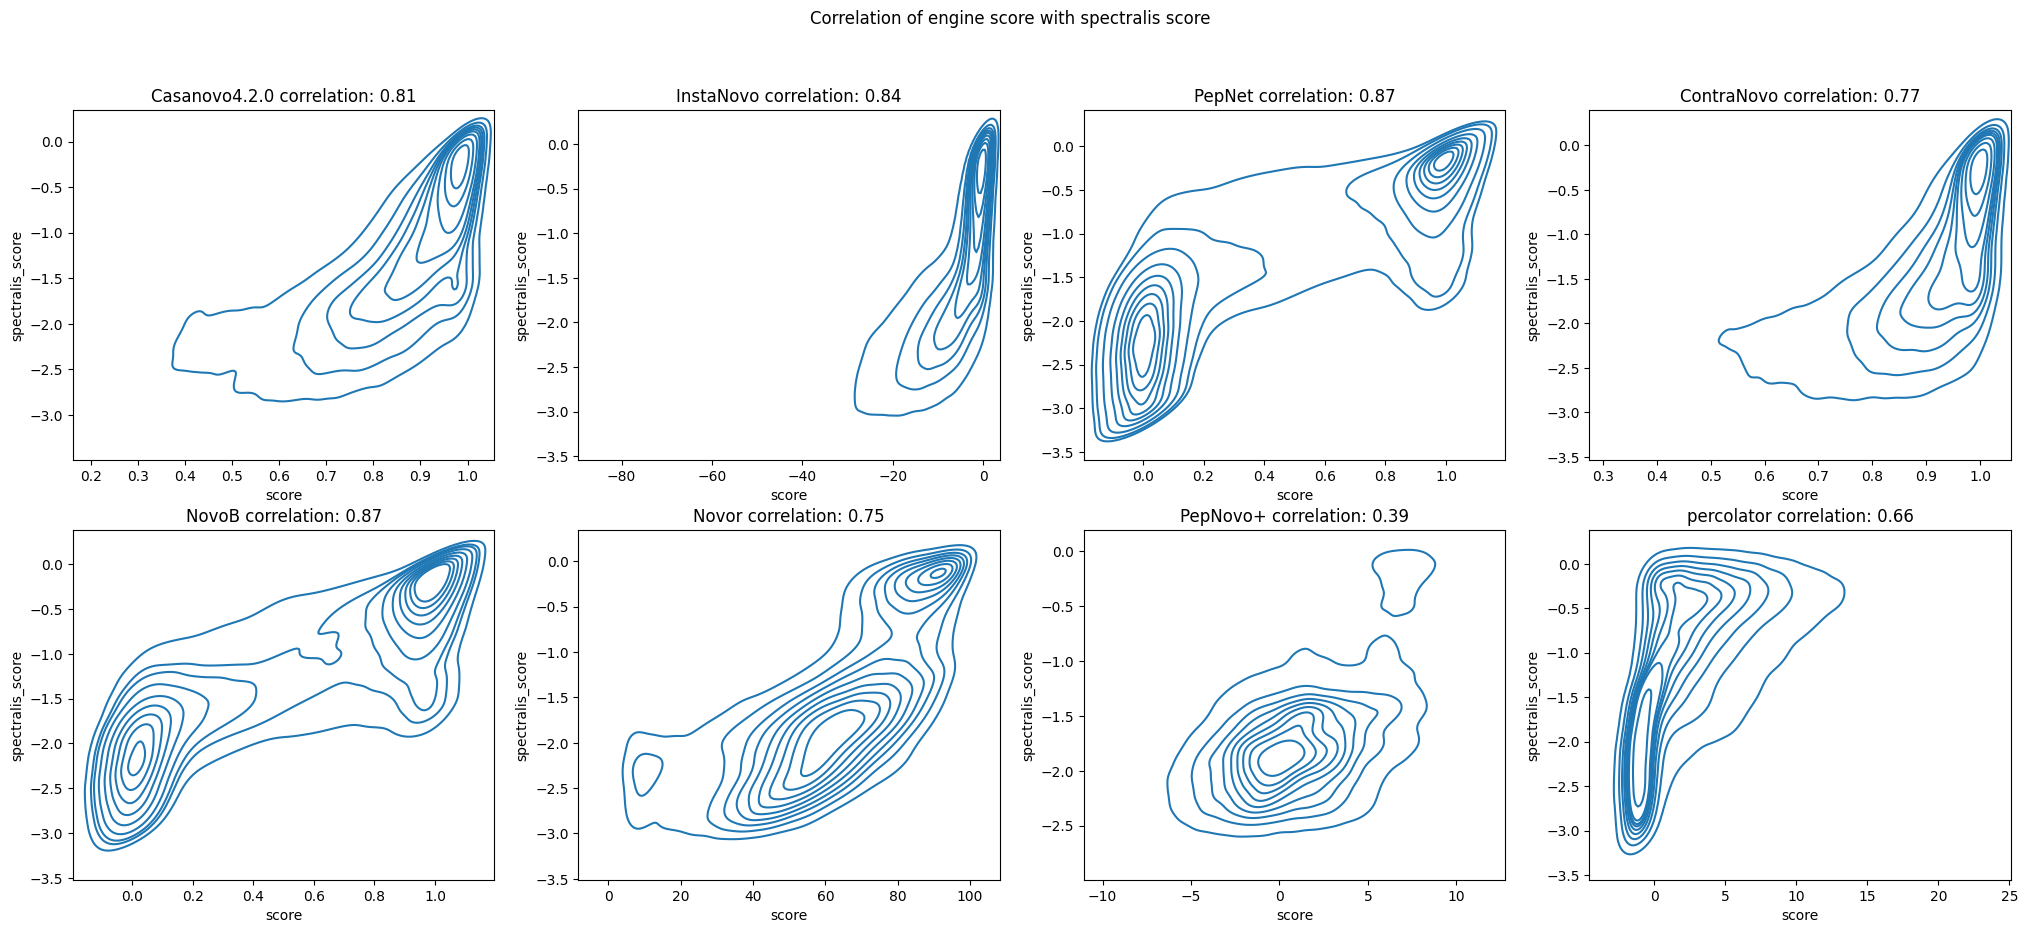

In [67]:
fig, ax = plt.subplots(2,4, figsize=(25,10))
x=0

fig.suptitle("Correlation of engine score with spectralis score")
for y, engine in enumerate(df.source.unique()):
    if y >= 4:
        x=1
        y-=4
    ax_selection = ax[x][y]
    plot_correlation_scores(df, source=engine, ax=ax_selection, plot_type="kde")
    ax_selection.set_title("{} correlation: {:.2f}".format(
        engine,
        spearmanr(
            df.loc[df["source"]==engine, "score"],
            df.loc[df["source"]==engine, "spectralis_score"]
        )[0]
    ))

The threshold for significance is around score 0

In [72]:
def get_decoy_status(row):
    proteins = row["protein_list"]
    for protein in proteins:
        if "decoy" in protein:
            return True
    return False

df_percolator["is_decoy"] = df_percolator.apply(get_decoy_status, axis=1)

Text(0.5, 1.0, 'Distribution spectralis scores target-decoy')

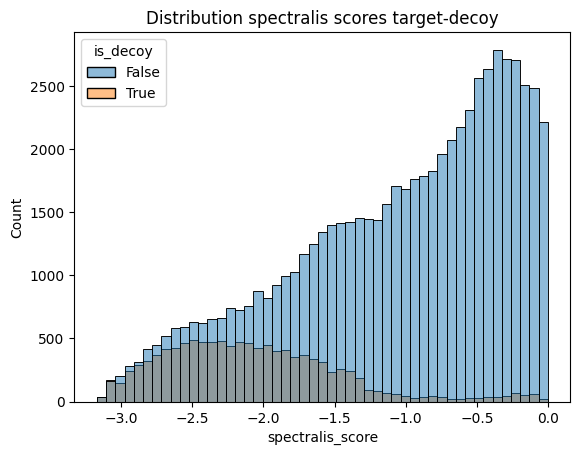

In [73]:
sns.histplot(
    df_percolator,
    x="spectralis_score",
    hue="is_decoy"
)
plt.title("Distribution spectralis scores target-decoy")

<Axes: xlabel='score', ylabel='Count'>

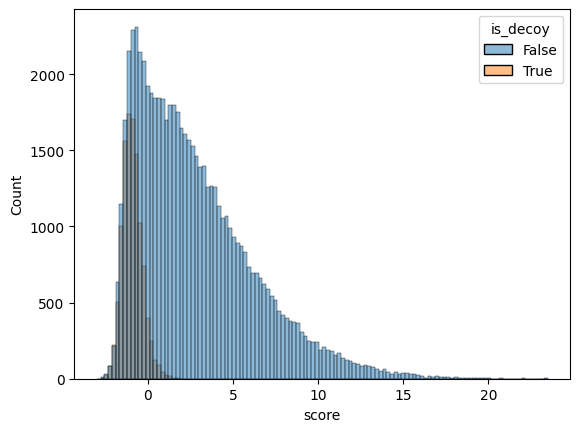

In [74]:
sns.histplot(
    df_percolator,
    x="score",
    hue="is_decoy"
)

Text(0.5, 1.0, 'Distribution spectralis scores targets below and above 1%')

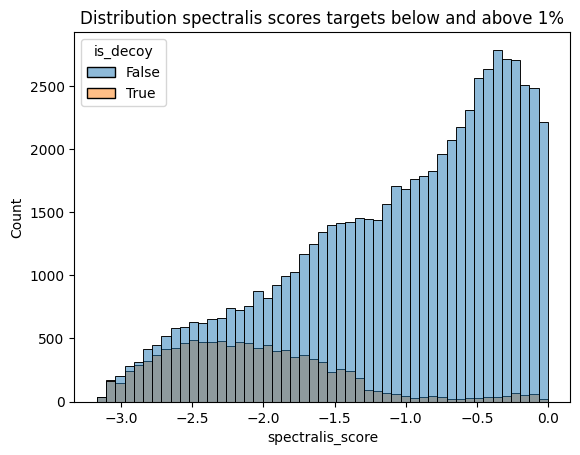

In [75]:
sns.histplot(
    df_percolator,
    x="spectralis_score",
    hue="is_decoy"
)
plt.title("Distribution spectralis scores targets below and above 1%")

Text(0.5, 1.0, 'Distribution percolator scores targets below and above 1%')

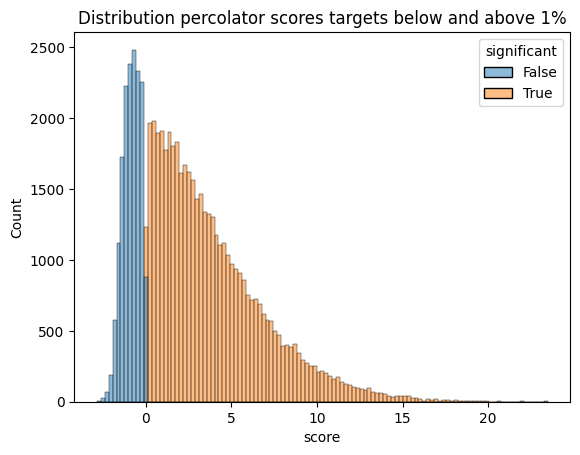

In [33]:
sns.histplot(
    df_percolator,
    x="score",
    hue="significant"
)
plt.title("Distribution percolator scores targets below and above 1%")

---

In [76]:
import numpy as np
class _ECDF:
    """
    Return the Empirical CDF of an array as a step function.

    Parameters
    ----------
    x : array_like
        Observations
    """

    def __init__(self, x):
        # Get ECDF
        x = np.array(x, copy=True)
        x.sort()
        nobs = len(x)
        y = np.linspace(1.0 / nobs, 1, nobs)

        # Make into step function
        _x = np.asarray(x)
        _y = np.asarray(y)

        if _x.shape != _y.shape:
            msg = "x and y do not have the same shape"
            raise ValueError(msg)
        if len(_x.shape) != 1:
            msg = "x and y must be 1-dimensional"
            raise ValueError(msg)

        self.x = np.r_[-np.inf, _x]
        self.y = np.r_[0.0, _y]
        self.n = self.x.shape[0]

    def __call__(self, time):
        tind = np.searchsorted(self.x, time, side="right") - 1
        return self.y[tind]
    
def pp_plot(psms, ax, before=False):
    """
    Generate PP plot of target and decoy score distributions.

    Parameters
    ----------
    psms
        PSMs to plot, as :py:class:`psm_utils.PSMList` or :py:class:`pandas.DataFrame` generated
        with :py:meth:`psm_utils.PSMList.to_dataframe`.

    """
    psm_df = psms.to_dataframe()


    n_decoys = np.count_nonzero(psm_df["is_decoy"])
    n_targets = len(psm_df) - n_decoys
    pi_zero = n_decoys / n_targets
    if n_decoys == 0:
        raise ValueError("No decoy PSMs found in PSM file.")
    if before:
        target_scores = [psm.rescoring_features["x_corr_score"] for psm in psms if not psm.is_decoy]
        decoy_scores = [psm.rescoring_features["x_corr_score"] for psm in psms if psm.is_decoy]
    else:
        target_scores = psm_df["score"][~psm_df["is_decoy"]]
        decoy_scores = psm_df["score"][psm_df["is_decoy"]]
    if len(psm_df) > 1000:
        target_scores_quantiles = psm_df["score"][~psm_df["is_decoy"]].quantile(
            np.linspace(0, 1, 1000)
        )
    else:
        target_scores_quantiles = target_scores
    target_ecdf = _ECDF(target_scores)(target_scores_quantiles)
    decoy_ecdf = _ECDF(decoy_scores)(target_scores_quantiles)

    sns.scatterplot(y=target_ecdf,x=decoy_ecdf, ax=ax, color="blue", s=6, alpha=0.5)
    sns.lineplot(x=[0, 1], y=[0, pi_zero], color="red", ax=ax)
    ax.set_ylabel("Target PSMs")
    ax.set_xlabel("Decoy PSMs")
    
    return ax

In [78]:
from psm_utils import PSM, PSMList

In [79]:
percolator_psmlist = PSMList(psm_list=[PSM(**x) for x in df_percolator.to_dict("records")])

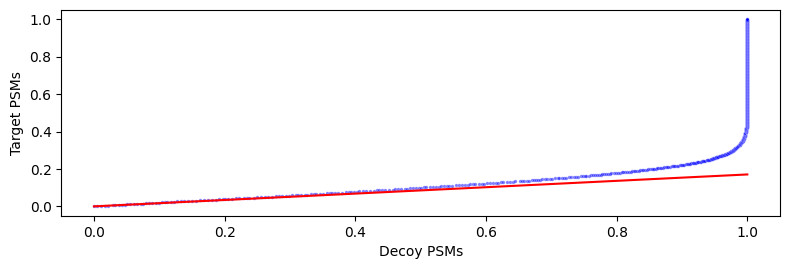

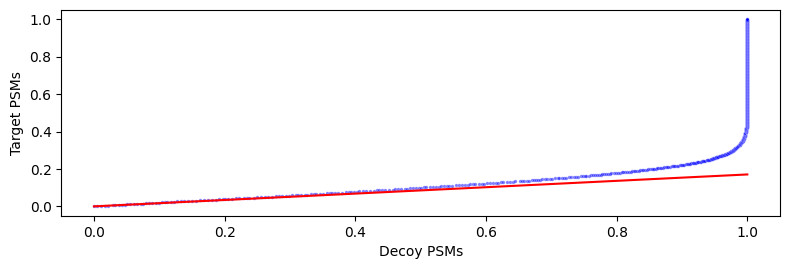

In [80]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(211)
pp_plot(percolator_psmlist, ax, before=False)
fig.tight_layout()
fig

The XTandem results look a bit skewed, so now searching with Sage to see if the results look a bit better...